# Assignment 3
## Group Members:
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se
***

## Part 3: Implementing your stance classification system
***

## Task 1: Load the dataset
***

In [57]:
# Install required packages
import pandas as pd
import numpy as np
import re
from collections import Counter
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Specify dataset column names
column_names = ['sentiment', 'comments']

# Load dataset
sample_df = pd.read_csv('data/a3_first_sample.tsv', sep='\t', header=None, names=column_names)
training_df = pd.read_csv('data/a3_train_final.tsv', sep='\t', header=None, names=column_names) 
test_df = pd.read_csv('data/a3_test.tsv', sep='\t', header=None, names=column_names)

# Display first 10 rows of the datasets
training_df.head(10)

,sentiment,comments
0,1/1,I'll only consume if I know what's inside it....
1,0/-1,It is easier to fool a million people than it...
2,0/0,NATURAL IMMUNITY protected us since evolutio...
3,0/-1,NATURAL IMMUNITY protected us since evolutio...
4,0/0,"Proud to have resisted. Proud of my husband, ..."
5,1/1/1/-1,The bigest sideffect of vaccines is fewer dea...
6,1/-1,Unvaccinated people are more likely to become...
7,1/1,Vaccine takes more than a year to develop. T...
8,0/0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...
9,0/0,"covid vaccines are safe , Goes to show , if ..."


In [58]:
# Information about the dataset
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  975 non-null    int64 
 1   comments   975 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


In [59]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50068 entries, 0 to 50067
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50068 non-null  object
 1   comments   50068 non-null  object
dtypes: object(2)
memory usage: 782.4+ KB


In [60]:
# Check for missing values
sample_df.isnull().sum()

sentiment    0
comments     0
dtype: int64

In [61]:
training_df.isnull().sum()

sentiment    0
comments     0
dtype: int64

In [62]:
# Count the frequency of each unique sentiment combination
sentiment_counts = training_df['sentiment'].value_counts()

# Calculate the consensus metrics
total_rows = len(training_df)
full_consensus_count = sentiment_counts[sentiment_counts.index.map(lambda x: len(set(x.split('/'))) == 1)].sum()
partial_consensus_count = total_rows - full_consensus_count

# Calculate the percentages
full_consensus_percentage = (full_consensus_count / total_rows) * 100
partial_consensus_percentage = (partial_consensus_count / total_rows) * 100

# Print the consensus analysis
print(f"Total number of rows: {total_rows}")
print(f"Rows with full consensus: {full_consensus_count} ({full_consensus_percentage:.2f}%)")
print(f"Rows with partial or no consensus: {partial_consensus_count} ({partial_consensus_percentage:.2f}%)")

# Display the frequency of each unique sentiment combination
print("\nFrequency of each unique sentiment combination:")
print(sentiment_counts)

Total number of rows: 50068
Rows with full consensus: 42247 (84.38%)
Rows with partial or no consensus: 7821 (15.62%)

Frequency of each unique sentiment combination:
1/1                            19248
0/0                            18221
0/-1                            2434
1/-1                            2082
1/0                             1467
                               ...  
0/1/0/0/0                          1
0/0/1/-1                           1
1/1/1/1/1/1/1/1/1/0/1/1/1/1        1
0/1/0/1/1/0/0/1                    1
1/0/-1/-1                          1
Name: sentiment, Length: 190, dtype: int64


## Task 2: Majority Vote Sentiment Combination Approach
***

In [63]:
def extract_majority_label(labels):
    """
    Extracts the majority label from a string of annotations separated by '/'.
    Returns None if there's no clear majority.
    """
    label_counts = Counter(labels.split('/'))
    most_common = label_counts.most_common()

    # Check if there's a clear majority or a tie
    # If there's a tie, return None
    # If there's a clear majority, return the majority label
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return None
    return most_common[0][0]

In [64]:
# Apply the function to extract the majority label or filter out non-consensus comments
training_df['major_sentiment'] = training_df['sentiment'].apply(extract_majority_label)

# Filter out rows where major_sentiment has no consensus
consensus_data = training_df.dropna(subset=['major_sentiment'])
consensus_data = consensus_data.drop(columns=['sentiment']).rename(columns={'major_sentiment': 'sentiment'})

# Display the first few rows of the consensus dataframe and the size of the filtered data
print(consensus_data)
print(f"\nSize of the filtered data: {consensus_data.shape}")

                                                comments sentiment
0       I'll only consume if I know what's inside it....         1
2       NATURAL IMMUNITY  protected us since evolutio...         0
4       Proud to have resisted. Proud of my husband, ...         0
5       The bigest sideffect of vaccines is fewer dea...         1
7       Vaccine takes more than a year to develop.  T...         1
...                                                  ...       ...
50063  🤣 keep your 💩 I already know 3 people who have...         0
50064  🤣🤣🤣 "JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...         0
50065  🤣🤣🤣 I took the Vaccine because of work. If I d...         0
50066  🤨there's people already having severe side eff...         0
50067  🥦I ❤my covid vaccines and I'm so excited for m...         1

[42840 rows x 2 columns]

Size of the filtered data: (42840, 2)


## Task 3.1: Text Preprocessing
***

In [65]:
def simple_preprocess(sentence):
    """Perform preprocessing of text without removing special characters that might affect sentiment."""
    sentence = str(sentence)
    sentence = re.sub(r'http\S+', '', sentence)  # Remove URLs
    sentence = re.sub(r'www\S+', '', sentence)   # Remove URLs
    sentence = re.sub(r'\n', ' ', sentence)      # Replace newline characters with space
    sentence = re.sub(r'\s\s+', ' ', sentence)   # Replace multiple spaces with a single space
    return sentence.strip()

In [66]:
def get_sentiment(sentence):
    """Extract sentiment from text based on polarity value using the TextBlob library."""
    score = TextBlob(sentence).sentiment.polarity
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

def get_subjectivity(sentence):
    """Calculate subjectivity of text using the TextBlob library."""
    return TextBlob(sentence).sentiment.subjectivity

In [67]:
def further_preprocess(sentence):
    """Apply further in depth cleaning and normalization after sentiment analysis."""
    sentence = sentence.lower()
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
    sentence = re.sub(r'[0-9]+', '', sentence)
    sentence = re.sub(r'\s\s+', ' ', sentence)
    return sentence.strip()

In [68]:
# Preprocess the text using spaCy's lemmatization and stop word removal
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Add additional stop words to spaCy's stop words list
additional_stop_words = [
    'vaccine', 'vaccination', 'vaccinate', 'vaccinated', 'use', 'people', 'person', 'like', 'think', 'know', 'case', 'want', 'mean', 'find', 'read', 'point'
]

for word in additional_stop_words:
    nlp.vocab[word].is_stop = True

# Lemmatization function
def lemmatize(sentence):
    doc = nlp(sentence, disable=['ner', 'parser'])
    lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(lemmas)

In [69]:
# Filter out the instances with a sentiment value of -1
# Given the small sample size of 22 instances we decided exclude these instances
consensus_data = consensus_data[consensus_data['sentiment'] != '-1']

# Basic Preprocessing on training and test datasets
consensus_data['basic_cleaned'] = consensus_data['comments'].apply(simple_preprocess)
test_df['basic_cleaned'] = test_df['comments'].apply(simple_preprocess)

# TextBlob Sentiment and Subjectivity Analysis
consensus_data['calculated_sentiment'] = consensus_data['basic_cleaned'].apply(get_sentiment)
consensus_data['calculated_subjectivity'] = consensus_data['basic_cleaned'].apply(get_subjectivity)

# Further Cleaning and Normalization on training and test datasets
consensus_data['further_cleaned'] = consensus_data['basic_cleaned'].apply(further_preprocess)
test_df['further_cleaned'] = test_df['basic_cleaned'].apply(further_preprocess)

# Lemmatization and Stop Word Removal on training and test datasets
consensus_data['final_text'] = consensus_data['further_cleaned'].apply(lemmatize)
test_df['final_text'] = test_df['further_cleaned'].apply(lemmatize)

# Display the top 10 instances on the training dataset
consensus_data.head(10)

,comments,sentiment,basic_cleaned,calculated_sentiment,calculated_subjectivity,further_cleaned,final_text
0,I'll only consume if I know what's inside it....,1,I'll only consume if I know what's inside it. ...,Neutral,1.000000,i'll only consume if i know what's inside it s...,consume inside drink monster taurine
2,NATURAL IMMUNITY protected us since evolutio...,0,NATURAL IMMUNITY protected us since evolution....,Positive,0.400000,natural immunity protected us since evolution ...,natural immunity protect evolution exist anymore
4,"Proud to have resisted. Proud of my husband, ...",0,"Proud to have resisted. Proud of my husband, m...",Positive,0.708333,proud to have resisted proud of my husband my ...,proud resist proud husband mother family prote...
5,The bigest sideffect of vaccines is fewer dea...,1,The bigest sideffect of vaccines is fewer dead...,Negative,0.400000,the bigest sideffect of vaccines is fewer dead...,bigest sideffect vaccine few dead child savage
7,Vaccine takes more than a year to develop. T...,1,Vaccine takes more than a year to develop. Thi...,Positive,0.500000,vaccine takes more than a year to develop this...,take year develop mistake make anymore vaccine...
8,YES IM A TRUCKER FROM USA AND I WONT GET VACC...,0,YES IM A TRUCKER FROM USA AND I WONT GET VACCI...,Neutral,0.000000,yes im a trucker from usa and i wont get vacci...,yes m trucker usa will not retweet follow patr...
9,"covid vaccines are safe , Goes to show , if ...",0,"covid vaccines are safe , Goes to show , if en...",Positive,0.500000,covid vaccines are safe goes to show if enough...,covid vaccine safe go money pay
11,out of anger People say stupid things man is ...,1,out of anger People say stupid things man is s...,Negative,0.335714,out of anger people say stupid things man is s...,anger stupid thing man spot get m year old old...
13,... it's been politicized in a way that has co...,0,... it's been politicized in a way that has co...,Neutral,0.000000,it's been politicized in a way that has cost l...,politicize way cost life investigate hold acco...
15,... vaccines are safe and effective. Why? Beca...,0,... vaccines are safe and effective. Why? Beca...,Positive,0.650000,vaccines are safe and effective why because we...,vaccine safe effective say


## Task 3.2: Sentiment Analysis
***

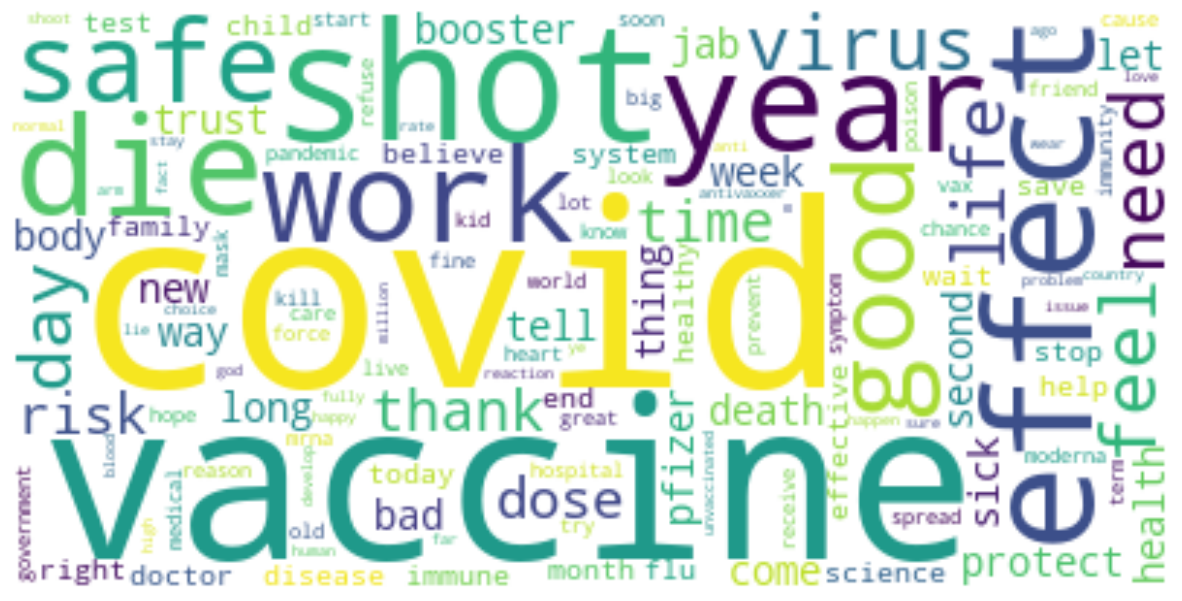

In [70]:
# Combined set of stop words to use in the WordCloud
stop_words = set(nlp.Defaults.stop_words)

# Concatenate all the comments into a single string
comments_words = ' '.join(consensus_data['final_text'].astype(str))

# Generate a word cloud image using the combined set of stop words
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200, collocations=False).generate(comments_words)

# Display the generated word cloud
plt.figure(figsize=(15, 10))
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

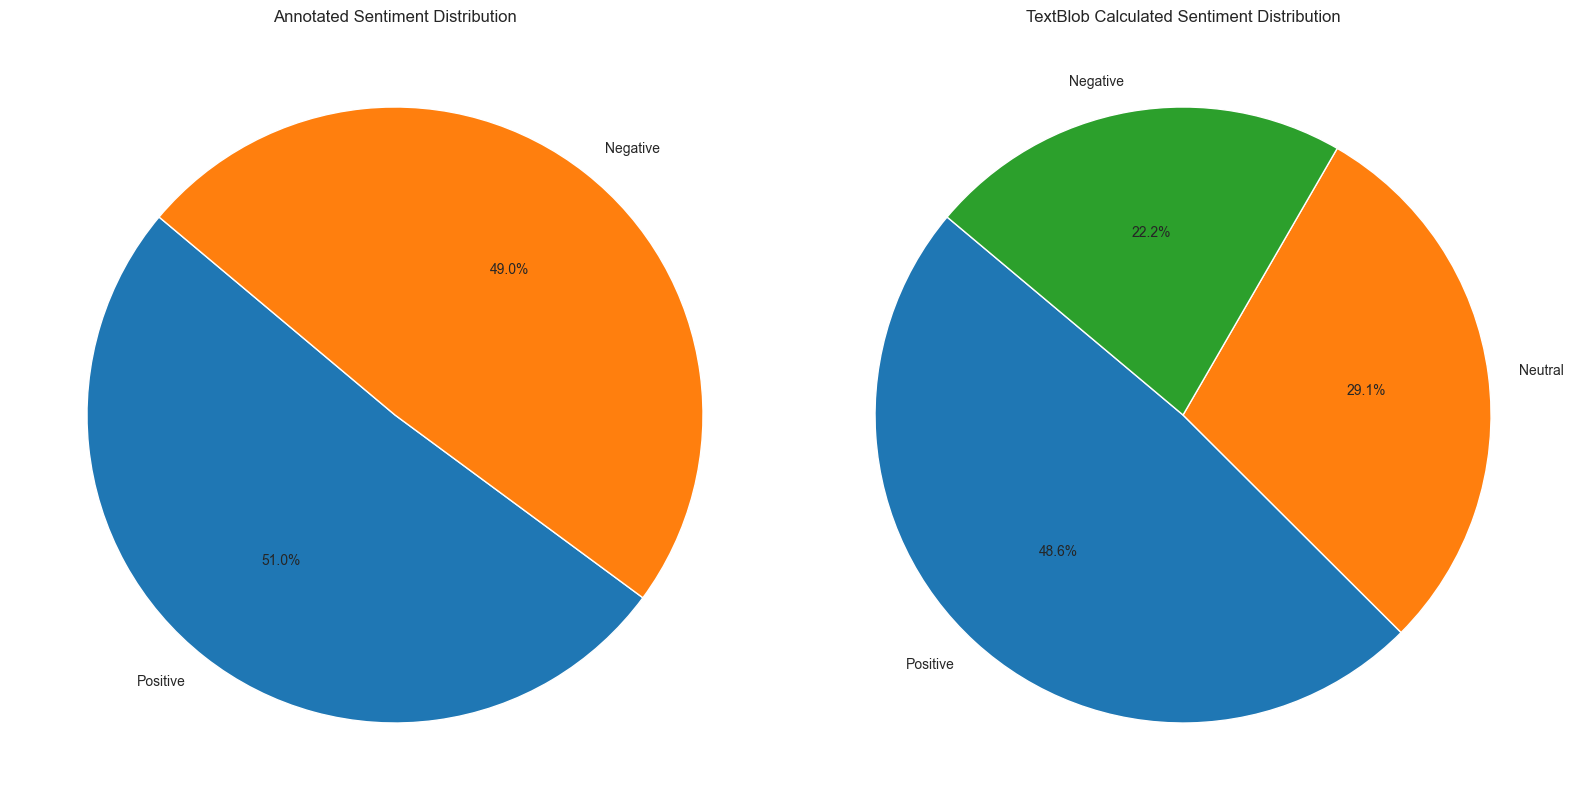

In [71]:
# Display the difference in distribution between the annotated and Textblob calculated sentiment
# Map the sentiment values to descriptive categories
sentiment_mapping = {'1': 'Positive', '0': 'Negative'}
consensus_data['sentiment_label'] = consensus_data['sentiment'].map(sentiment_mapping)

# Create pie charts for both annotated and calculated sentiment distributions
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Annotated Sentiment Distribution
original_sentiment_counts = consensus_data['sentiment_label'].value_counts(normalize=True)
original_labels = original_sentiment_counts.index

axs[0].pie(original_sentiment_counts, labels=original_labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Annotated Sentiment Distribution')

# TextBlob Calculated Sentiment Distribution
calculated_sentiment_counts = consensus_data['calculated_sentiment'].value_counts(normalize=True)
calculated_labels = calculated_sentiment_counts.index

axs[1].pie(calculated_sentiment_counts, labels=calculated_labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title('TextBlob Calculated Sentiment Distribution')

plt.tight_layout()
plt.show()

In [72]:
def sample_and_compare_sentiment(data, sentiment_type, num_samples=5):
    """
    Samples comments identified with a specific sentiment by TextBlob,
    and compares them with the actual sentiment annotations.
    """
    # Sample instances based on TextBlob identified sentiment
    sampled_comments = data.loc[data['calculated_sentiment'] == sentiment_type, 'comments'].sample(num_samples)

    print(f"Sample comments classified as {sentiment_type} by TextBlob:")
    for i, comment in enumerate(sampled_comments, start=1):
        print(f"{i}. {comment}")

    # Find indices of the sampled comments
    sample_indices = sampled_comments.index

    # Display actual sentiment for these samples
    print(f"\nActual sentiment for the sampled comments classified as {sentiment_type}:")
    for idx in sample_indices:
        actual_sentiment = data.loc[idx, 'sentiment']
        sentiment_label = "Pro-Vaccine" if actual_sentiment == '1' else "Anti-Vaccine"
        print(f"Comment {idx}: {sentiment_label}")
    print()
        
# Sample and compare comments classified as positive and Negative by TextBlob to the actual annotations
sample_and_compare_sentiment(consensus_data, 'Positive')
sample_and_compare_sentiment(consensus_data, 'Negative')

Sample comments classified as Positive by TextBlob:
1. Do you really think all the governments around the world are lying about the seriousness of COVID, and about vaccine safety & efficacy?
2. Im good, i dont put anything in my body that takes less than a year to create. Proper vaccine takes years to make. This is a huge NO for me.
3. For those of you who come here to argue vaccines are still awesome and this avalanche of humans who #diedsuddenly is just a coincidence, you are sheep
4. MY EXPERIENCE: I've had 3 full dose Moderna vaccinations, a normal booster and a bivalent booster shot. 5x. Completely healthy, not even a cold for almost 3 years and ZERO side effects. I have never had Covid.
5. I made my appointment in advance waiting for high risk health issues to be eligible in my state and have been so eager to get it and protect myself

Actual sentiment for the sampled comments classified as Positive:
Comment 5965: Pro-Vaccine
Comment 21234: Anti-Vaccine
Comment 7684: Anti-Vaccine

### Task 3.3: Subjectivity Analysis
***

In [73]:
# Describe the subjectivity in the comments
consensus_data['calculated_subjectivity'].describe()

count    42818.000000
mean         0.406248
std          0.298956
min          0.000000
25%          0.100000
50%          0.444610
75%          0.602083
max          1.000000
Name: calculated_subjectivity, dtype: float64

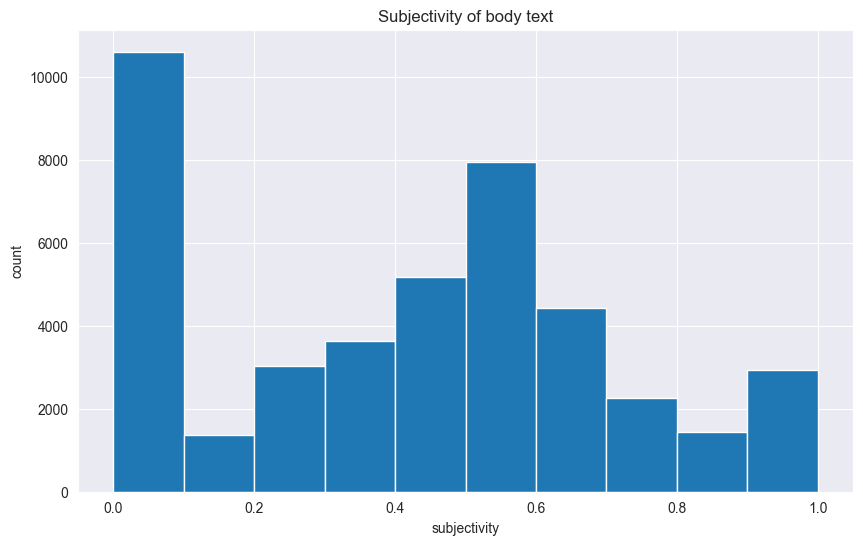

In [74]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(consensus_data['calculated_subjectivity'])
plt.title('Subjectivity of body text')
plt.xlabel('subjectivity')
plt.ylabel('count')
plt.show();

### Task 4.1: Machine Learning Data Preparation
***

In [75]:
# Split the training and final test data into features and target
X = consensus_data['final_text']
y = consensus_data['sentiment']
X_test_final = test_df['final_text']
y_test_final = test_df['sentiment']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

## Task 4.2: Evaluating Baseline Models
***

In [76]:
# Function to create, fit, evaluate and plot a confusion matrix of a model
def evaluate_model_and_plot_confusion_matrix(model, X_train, X_val, y_train, y_val, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{title} Results:")
    print(classification_report(y_val, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy}")

    # Plotting the confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {title}')
    plt.show()

Dummy Classifier with TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6231
           1       0.51      1.00      0.68      6615

    accuracy                           0.51     12846
   macro avg       0.26      0.50      0.34     12846
weighted avg       0.27      0.51      0.35     12846

Accuracy: 0.5149462867818776


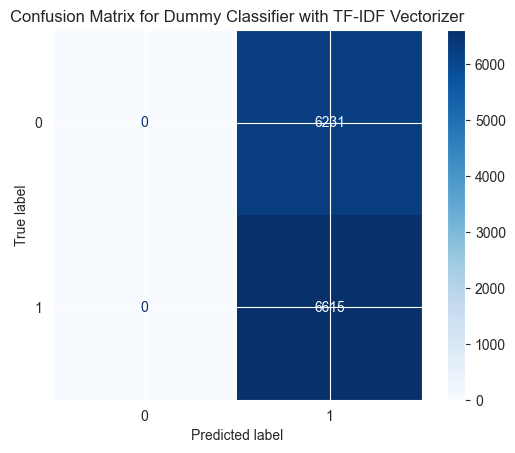

Dummy Classifier with CountVectorizer Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6231
           1       0.51      1.00      0.68      6615

    accuracy                           0.51     12846
   macro avg       0.26      0.50      0.34     12846
weighted avg       0.27      0.51      0.35     12846

Accuracy: 0.5149462867818776


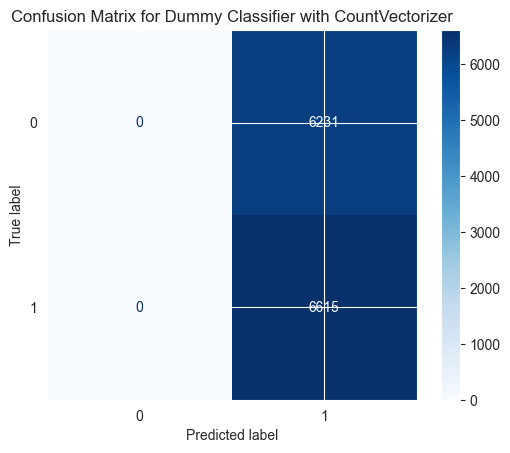

Logistic Regression with TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6231
           1       0.81      0.82      0.81      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846

Accuracy: 0.8061653432975245


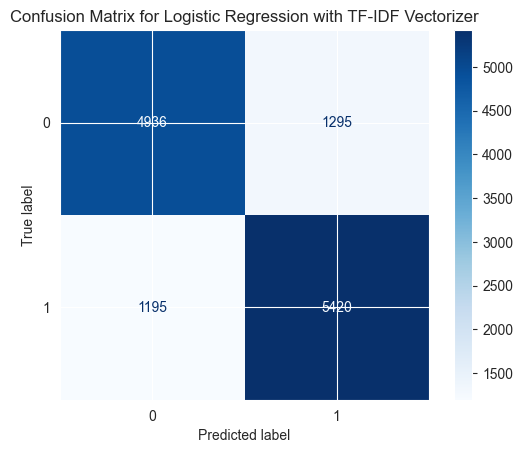

C:\Users\nilsd\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression with CountVectorizer Results:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      6231
           1       0.81      0.79      0.80      6615

    accuracy                           0.80     12846
   macro avg       0.80      0.80      0.80     12846
weighted avg       0.80      0.80      0.80     12846

Accuracy: 0.7974466760080959


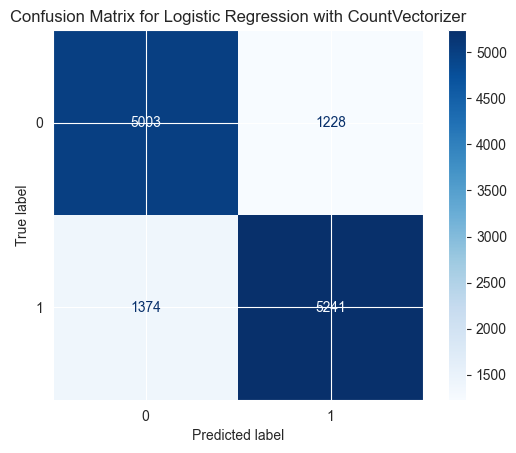

Naive Bayes with TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      6231
           1       0.79      0.86      0.82      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846

Accuracy: 0.8107582126732057


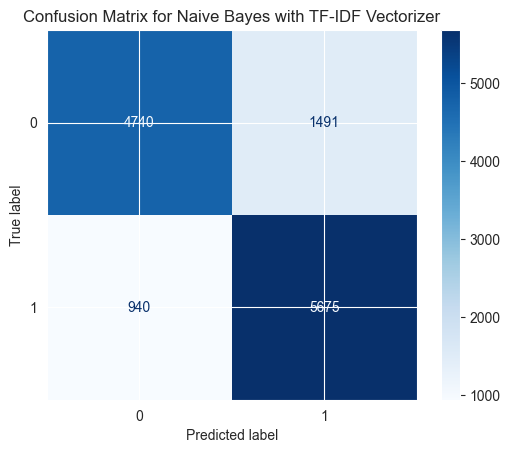

Naive Bayes with CountVectorizer Results:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      6231
           1       0.79      0.85      0.82      6615

    accuracy                           0.81     12846
   macro avg       0.81      0.81      0.81     12846
weighted avg       0.81      0.81      0.81     12846

Accuracy: 0.8082671648762261


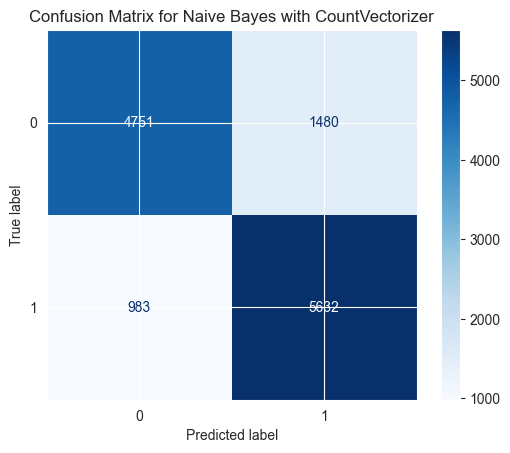

LinearSVC with TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      6231
           1       0.82      0.83      0.82      6615

    accuracy                           0.82     12846
   macro avg       0.82      0.82      0.82     12846
weighted avg       0.82      0.82      0.82     12846

Accuracy: 0.8153510820488868


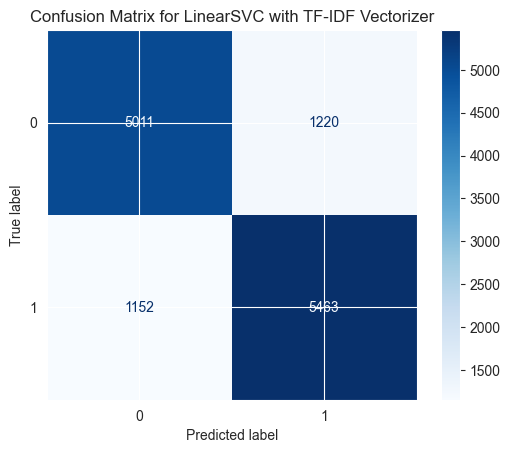

LinearSVC with CountVectorizer Results:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      6231
           1       0.82      0.79      0.80      6615

    accuracy                           0.80     12846
   macro avg       0.80      0.80      0.80     12846
weighted avg       0.80      0.80      0.80     12846

Accuracy: 0.8025066168457107


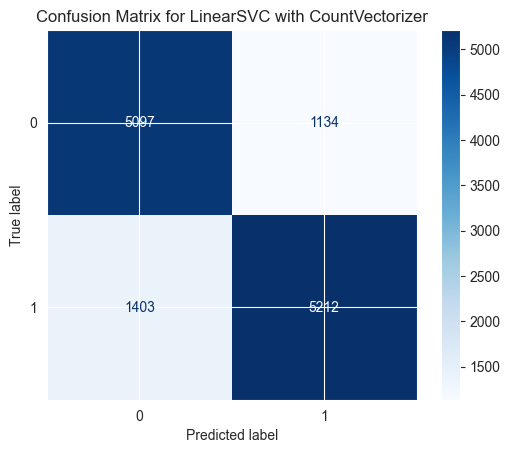

Random Forest with TF-IDF Vectorizer Results:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      6231
           1       0.81      0.77      0.79      6615

    accuracy                           0.79     12846
   macro avg       0.79      0.79      0.79     12846
weighted avg       0.79      0.79      0.79     12846

Accuracy: 0.7908298302973689


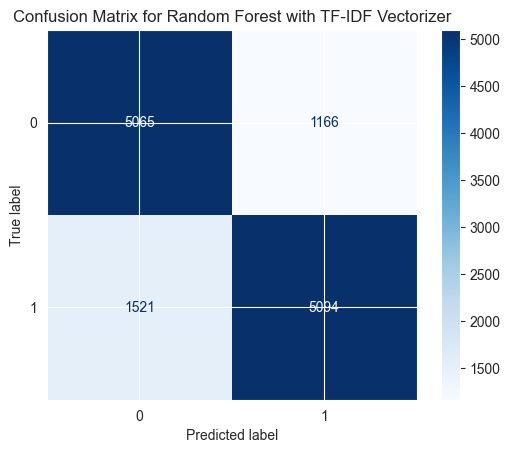

Random Forest with CountVectorizer Results:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      6231
           1       0.82      0.76      0.79      6615

    accuracy                           0.79     12846
   macro avg       0.79      0.79      0.79     12846
weighted avg       0.79      0.79      0.79     12846

Accuracy: 0.7900513778608127


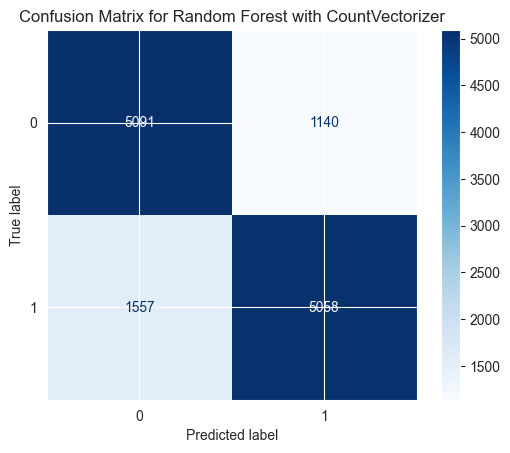

In [77]:
# Establish pipelines for the baseline models
# Dummy Classifier Pipelines
dummy_pipeline_tf = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), DummyClassifier(strategy='most_frequent', random_state=0))
dummy_pipeline_cv = make_pipeline(CountVectorizer(ngram_range=(1, 2)), DummyClassifier(strategy='most_frequent', random_state=0))
evaluate_model_and_plot_confusion_matrix(dummy_pipeline_tf, X_train, X_val, y_train, y_val, "Dummy Classifier with TF-IDF Vectorizer")
evaluate_model_and_plot_confusion_matrix(dummy_pipeline_cv, X_train, X_val, y_train, y_val, "Dummy Classifier with CountVectorizer")

# Logistic Regression Pipelines
lr_pipeline_tf = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LogisticRegression(C=1, solver='saga', max_iter=10000, random_state=0))
lr_pipeline_cv = make_pipeline(CountVectorizer(ngram_range=(1, 2)), LogisticRegression(C=1, solver='saga', max_iter=10000, random_state=0))
evaluate_model_and_plot_confusion_matrix(lr_pipeline_tf, X_train, X_val, y_train, y_val, "Logistic Regression with TF-IDF Vectorizer")
evaluate_model_and_plot_confusion_matrix(lr_pipeline_cv, X_train, X_val, y_train, y_val, "Logistic Regression with CountVectorizer")

# Naive Bayes Pipelines
nb_pipeline_tf = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())
nb_pipeline_cv = make_pipeline(CountVectorizer(ngram_range=(1, 2)), MultinomialNB())
evaluate_model_and_plot_confusion_matrix(nb_pipeline_tf, X_train, X_val, y_train, y_val, "Naive Bayes with TF-IDF Vectorizer")
evaluate_model_and_plot_confusion_matrix(nb_pipeline_cv, X_train, X_val, y_train, y_val, "Naive Bayes with CountVectorizer")

# SVC Pipelines
svc_pipeline_tf = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), LinearSVC(random_state=0))
svc_pipeline_cv = make_pipeline(CountVectorizer(ngram_range=(1, 2)), LinearSVC(random_state=0))
evaluate_model_and_plot_confusion_matrix(svc_pipeline_tf, X_train, X_val, y_train, y_val, "LinearSVC with TF-IDF Vectorizer")
evaluate_model_and_plot_confusion_matrix(svc_pipeline_cv, X_train, X_val, y_train, y_val, "LinearSVC with CountVectorizer")

# Random Forest Pipelines
rf_pipeline_tf = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), RandomForestClassifier(random_state=0))
rf_pipeline_cv = make_pipeline(CountVectorizer(ngram_range=(1, 2)), RandomForestClassifier(random_state=0))
evaluate_model_and_plot_confusion_matrix(rf_pipeline_tf, X_train, X_val, y_train, y_val, "Random Forest with TF-IDF Vectorizer")
evaluate_model_and_plot_confusion_matrix(rf_pipeline_cv, X_train, X_val, y_train, y_val, "Random Forest with CountVectorizer")

### Task 4.3: Hyperparameter Tuning
***

In [78]:
# Logistic Regression hyperparameter distribution for TF-IDF Vectorizer
lr_param_distributions_tf = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'logisticregression__C': loguniform(1e-4, 1e2),
    'logisticregression__penalty': ['l1', 'l2'],
}

# Set up RandomizedSearchCV for Logistic Regression
lr_random_search_tf = RandomizedSearchCV(
    lr_pipeline_tf,
    param_distributions=lr_param_distributions_tf,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search with TF-IDF Vectorizer
lr_random_search_tf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('logisticregression',
                                              LogisticRegression(C=1,
                                                                 random_state=0,
                                                                 solver='saga'))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020024FC5840>,
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'tfidfvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_cont

In [79]:
# Logistic Regression hyperparameter distribution for CountVectorizer
lr_param_distributions_cv = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'countvectorizer__max_df': uniform(0.7, 0.3),
    'countvectorizer__min_df': uniform(0.01, 0.05),
    'logisticregression__C': loguniform(1e-4, 1e2),
    'logisticregression__penalty': ['l1', 'l2'],
}

# Set up RandomizedSearchCV for Logistic Regression with CountVectorizer
lr_random_search_cv = RandomizedSearchCV(
    lr_pipeline_cv,
    param_distributions=lr_param_distributions_cv,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search with CountVectorizer
lr_random_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('logisticregression',
                                              LogisticRegression(C=1,
                                                                 random_state=0,
                                                                 solver='saga'))]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002002DD4E950>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002002DD4EB60>,
                                        'countvectorizer__ngram_range': [(1, 1),
                             

In [80]:
nb_param_grid_tf = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': [0.5, 0.7, 0.9],
    'tfidfvectorizer__min_df': [1, 2, 5],
    'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0],
}

# Set up RandomizedSearchCV for Multinomial Naive Bayes
nb_random_search_tf = RandomizedSearchCV(
    nb_pipeline_tf,
    param_distributions=nb_param_grid_tf,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
nb_random_search_tf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [89]:
nb_param_grid_cv = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'countvectorizer__max_df': [0.5, 0.7, 0.9],
    'countvectorizer__min_df': [1, 2, 5],
    'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0],
}

# Set up RandomizedSearchCV for Multinomial Naive Bayes
nb_random_search_cv = RandomizedSearchCV(
    nb_pipeline_cv,
    param_distributions=nb_param_grid_cv,
    n_iter=10,
    cv=5,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
nb_random_search_cv.fit(X_train, y_train)

# Obtain the best Naive Bayes model from the random search
nb_best_model = nb_random_search_cv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [83]:
# LinearSVC hyperparameter distribution
svc_param_distributions_tf = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'linearsvc__C': uniform(0.1, 10),
}

# Set up RandomizedSearchCV for LinearSVC
svc_random_search_tf = RandomizedSearchCV(
    svc_pipeline_tf,
    param_distributions=svc_param_distributions_tf,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
svc_random_search_tf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('linearsvc',
                                              LinearSVC(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'linearsvc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002001D0420B0>,
                                        'tfidfvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020021669120>,
                                        'tfidfvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002001D0419C0>,
                                        'tfidfvectorizer__ngram_range': [(1, 1),
                                                      

In [87]:
# LinearSVC hyperparameter distribution
svc_param_distributions_cv = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'countvectorizer__max_df': uniform(0.7, 0.3),
    'countvectorizer__min_df': uniform(0.01, 0.05),
    'linearsvc__C': uniform(0.1, 10),
}

# Set up RandomizedSearchCV for LinearSVC
svc_random_search_cv = RandomizedSearchCV(
    svc_pipeline_cv,
    param_distributions=svc_param_distributions_cv,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
svc_random_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\nilsd\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('linearsvc',
                                              LinearSVC(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002002168E980>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020021668070>,
                                        'countvectorizer__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                                        '

In [84]:
# Random Forest hyperparameter distribution
rf_param_distributions_tf = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__max_df': uniform(0.7, 0.3),
    'tfidfvectorizer__min_df': uniform(0.01, 0.05),
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

# Set up RandomizedSearchCV for Random Forest
rf_random_search_tf = RandomizedSearchCV(
    rf_pipeline_tf,
    param_distributions=rf_param_distributions_tf,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
rf_random_search_tf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [10,
                                                                              20,
                                                                              None],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'rando

In [85]:
# Random Forest hyperparameter distribution
rf_param_distributions_cv = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'countvectorizer__max_df': uniform(0.7, 0.3),
    'countvectorizer__min_df': uniform(0.01, 0.05),
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

# Set up RandomizedSearchCV for Random Forest
rf_random_search_cv = RandomizedSearchCV(
    rf_pipeline_cv,
    param_distributions=rf_param_distributions_cv,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# Perform the search
rf_random_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(ngram_range=(1,
                                                                           2))),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002000A372020>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002001D041060>,
                                        'countvectorizer__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
               

In [90]:
# Evaluate the best model from the RandomizedSearchCV
def evaluate_best_model(random_search, X_val, y_val):
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_val)
    print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
    print(classification_report(y_val, y_pred, zero_division=0))
    print(f"Best parameters: {random_search.best_params_}")

# Evaluate Logistic Regression best model
print("Best Logistic Regression Model:")
evaluate_best_model(lr_random_search_tf, X_val, y_val)
evaluate_best_model(lr_random_search_cv, X_val, y_val)

# Evaluate LinearSVC best model
print("\nBest LinearSVC Model:")
evaluate_best_model(svc_random_search_tf, X_val, y_val)
evaluate_best_model(svc_random_search_cv, X_val, y_val)

# Evaluate Random Forest best model
print("\nBest Random Forest Model:")
evaluate_best_model(rf_random_search_tf, X_val, y_val)
evaluate_best_model(rf_random_search_cv, X_val, y_val)

# Evaluate Multinomial Naive Bayes model
print("\nBest  Naive Bayes Model:")
evaluate_best_model(nb_random_search_tf, X_val, y_val)
evaluate_best_model(nb_random_search_cv, X_val, y_val)

Best Logistic Regression Model:
Test accuracy: 0.6553012610929472
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      6231
           1       0.69      0.61      0.64      6615

    accuracy                           0.66     12846
   macro avg       0.66      0.66      0.66     12846
weighted avg       0.66      0.66      0.65     12846

Best parameters: {'logisticregression__C': 0.13523525694052882, 'logisticregression__penalty': 'l1', 'tfidfvectorizer__max_df': 0.8420801258039972, 'tfidfvectorizer__min_df': 0.019316617166338, 'tfidfvectorizer__ngram_range': (1, 1)}
Test accuracy: 0.6012766619959521
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      6231
           1       0.63      0.53      0.58      6615

    accuracy                           0.60     12846
   macro avg       0.61      0.60      0.60     12846
weighted avg       0.61      0.60      0.60     12846

Best paramet

### Task 5.1: Best Model Evaluation
***

Classification Report (Cross-Validated):
              precision    recall  f1-score   support

           0       0.84      0.76      0.80     14750
           1       0.78      0.86      0.82     15222

    accuracy                           0.81     29972
   macro avg       0.81      0.81      0.81     29972
weighted avg       0.81      0.81      0.81     29972

Accuracy (Cross-Validated):
0.8084545575870813


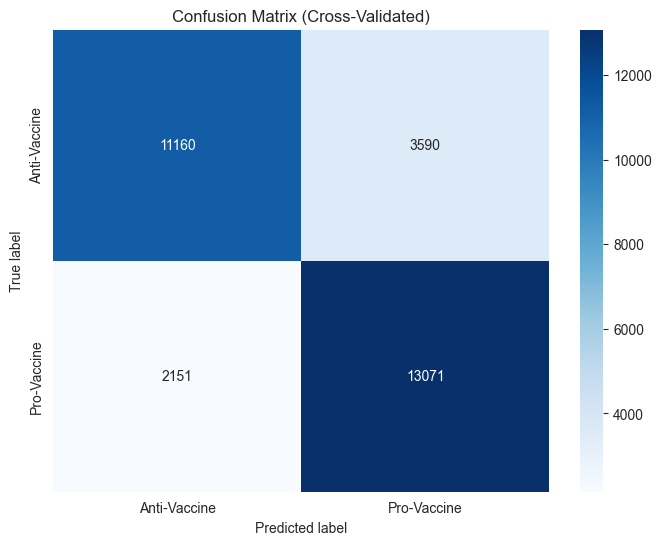

In [91]:
# Function to plot confusion matrix
def plot_confusion_matrix_of_best_model(y_true, y_pred, classes, title='Confusion matrix'):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Generate cross-validated estimates for each input data point
y_pred_cv = cross_val_predict(nb_best_model, X_train, y_train, cv=10)

# Evaluate the predicted target values and accuracy
print("Classification Report (Cross-Validated):")
print(classification_report(y_train, y_pred_cv))
print("Accuracy (Cross-Validated):")
print(accuracy_score(y_train, y_pred_cv))

# Plotting the confusion matrix using the custom function
plot_confusion_matrix_of_best_model(y_train, y_pred_cv, classes=['Anti-Vaccine', 'Pro-Vaccine'], title='Confusion Matrix (Cross-Validated)')

### Task 5.2: Evaluate Best Model On Final Test Set
***

Dummy Classifier Test Set Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1020
           1       0.50      1.00      0.67      1019

    accuracy                           0.50      2039
   macro avg       0.25      0.50      0.33      2039
weighted avg       0.25      0.50      0.33      2039

Accuracy: 0.49975478175576266

Classification Report of Naive Bayes Model on Final Test Set:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1020
           1       0.80      0.88      0.84      1019

    accuracy                           0.83      2039
   macro avg       0.83      0.83      0.83      2039
weighted avg       0.83      0.83      0.83      2039

Accuracy of Naive Bayes Model:
0.8298185384992643


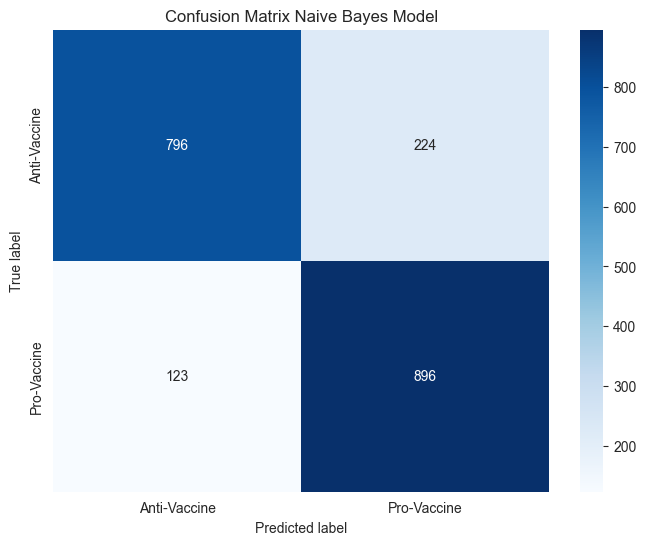

In [94]:
# Evaluating the Naive Bayes model on the separate test dataset
y_pred_test_final = nb_best_model.predict(X_test_final).astype(int)

# Predict the test set labels with the Dummy Classifier
dummy_pipeline.fit(X_train, y_train)
y_pred_test_dummy = dummy_pipeline.predict(X_test_final).astype(int)

# Evaluate performance of the Dummy Classifier
print("Dummy Classifier Test Set Results:")
print(classification_report(y_test_final, y_pred_test_dummy, zero_division=0))
print(f"Accuracy: {accuracy_score(y_test_final, y_pred_test_dummy)}")
print("")

# Evaluate performance of the Naive Bayes model
print("Classification Report of Naive Bayes Model on Final Test Set:")
print(classification_report(y_test_final, y_pred_test_final, zero_division=0))
print("Accuracy of Naive Bayes Model:")
print(accuracy_score(y_test_final, y_pred_test_final))

# Plot confusion matrix for the Naive Bayes and Dummy model
plot_confusion_matrix_of_best_model(y_test_final, y_pred_test_final, classes=['Anti-Vaccine', 'Pro-Vaccine'], title='Confusion Matrix Naive Bayes Model')

## Task 5.3: Sample Mispredicted Comments
***

In [95]:
# Retrieve the index of mispredicted comments
incorrect_indices = np.where(y_train != y_pred_cv)[0]

# Sample a few incorrect predictions
sample_incorrect_indices = np.random.choice(incorrect_indices, size=min(5, len(incorrect_indices)), replace=False)

print("Sample Incorrect Predictions:")
for idx in sample_incorrect_indices:
    original_idx = X_train.index[idx]  # Get the original index if X_train has been reset
    print(f"Index: {original_idx}, Predicted: {y_pred_cv[idx]}, Actual: {y_train.iloc[idx]}")
    print(f"Text: {consensus_data.loc[original_idx, 'comments']}\n")

Sample Incorrect Predictions:
Index: 48678, Predicted: 1, Actual: 0
Text: step daughter is in hospital on the stroke ward. she's had the AZ vaccine. she's 25 years old I'm beside myself

Index: 14656, Predicted: 1, Actual: 0
Text: I have covid right now and I was never vaccinated. Had a fever for the first two days but now I'm fine. My mom got the vaccine and booster (she has covid too) and shes a lot worse than me

Index: 27688, Predicted: 1, Actual: 0
Text: My youngest son became autistic after having the MMR vaccine. They are full of it

Index: 43185, Predicted: 0, Actual: 1
Text: Well everyone needs to get vaccinated to stop the spread, that's the only solution to wiping out these variants, make it law, get vaccinated or go to jail lol

Index: 40426, Predicted: 1, Actual: 0
Text: URGENT! No more vaccination pass obtained with an infection! Olivier Véran announced this evening that it will be necessary to have received at least one dose of vaccine and an infection to obtain the vacc

## References
***
- scikit-learn. (2024). sklearn.feature_extraction.text.CountVectorizer. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html [Accessed 14 Feb. 2024].

- scikit-learn. (2024). sklearn.feature_extraction.text.TfidfVectorizer. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html [Accessed 14 Feb. 2024].

- scikit-learn. (2024). sklearn.model_selection.RandomizedSearchCV. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html [Accessed 14 Feb. 2024].

- Pandian, S. (2022). A Comprehensive Guide on Hyperparameter Tuning and its Techniques. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2022/02/a-comprehensive-guide-on-hyperparameter-tuning-and-its-techniques/ [Accessed 18 Feb. 2024].

- Valohai.com. (2022). What is a Machine Learning Pipeline? [online] Available at: https://valohai.com/machine-learning-pipeline/ [Accessed 18 Feb. 2024].

- Readthedocs.io. (2024). TextBlob: Simplified Text Processing — TextBlob 0.18.0.post0 documentation. [online] Available at: https://textblob.readthedocs.io/en/dev/ [Accessed 18 Feb. 2024].

- Harshith (2019). Text Preprocessing in Natural Language Processing - Towards Data Science. [online] Medium. Available at: https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8 [Accessed 18 Feb. 2024].